In [1]:
import json
import numpy as np
import re
import os
import pickle
from random import shuffle
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Embedding, Flatten, Conv1D, MaxPooling1D, GlobalMaxPool1D
from matplotlib import pyplot as plt
from gensim.models import Word2Vec
from constants import *

Using TensorFlow backend.


In [2]:
def plt_history(data, filename):
    plt.title('Model accuracy')
    for i in data[:2]:
        plt.plot(i)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['acc', 'val_acc'])
    plt.grid()
    plt.savefig(os.path.join('graph', 'acc_' + filename + '.png'))
    plt.show()
    plt.title('Model accuracy')
    for i in data[2:]:
        plt.plot(i)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['loss', 'val_loss'])
    plt.grid()
    plt.savefig(os.path.join('graph', 'loss_' + filename + '.png'))
    plt.show()

In [3]:
def train_model(model, x_train, y_train, batch_size, epochs, data):
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=VAL_SIZE, verbose=False)
    data[0] += history.history['acc']
    data[1] += history.history['val_acc']
    data[2] += history.history['loss']
    data[3] += history.history['val_loss']
    return data

In [4]:
def pro_train(model, x_train, y_train, batch_size, filename):
    data = [[],[],[],[]]
    cont = True
    best_acc = 0

    while cont:
        data = train_model(model, x_train, y_train, batch_size, 1, data)
        if best_acc < data[1][-1]:
            best_acc = data[1][-1]
            model.save('model/' + filename)
        if len(data[3]) > 2:
            if data[3][-1] > data[3][-2] and data[3][-2] > data[3][-3]:
                cont = False
    
    model = load_model('model/' + filename)
    return model, data

In [5]:
def load_tokenizer(filename):
    with open(filename, 'rb') as f:
        t = pickle.load(f)
    return t

In [6]:
def laod_gen_emb():
    with open(EMBEDDINGS_FILENAME, 'r') as f:
        raw_embeddings = f.readlines()

    embeddings_index = {}

    for line in raw_embeddings:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        if word in tokenizer.word_index:
            embeddings_index[word] = coefs

    del raw_embeddings
    return embeddings_index

In [7]:
def paddear(tokenizer, train, test, pad):
    encoded_train = tokenizer.texts_to_sequences([item[0] for item in train])
    encoded_test = tokenizer.texts_to_sequences([item[0] for item in test])

    padded_train = pad_sequences(encoded_train, pad)
    padded_test = pad_sequences(encoded_test, pad)

    del encoded_train
    del encoded_test
    return padded_train, padded_test

In [8]:
def get_matrix(tokenizer, embeddings_index):
    vocab_size = len(tokenizer.word_index) + 1
    embedding_matrix = np.zeros((vocab_size, 100))
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    del embeddings_index
    return embedding_matrix

In [9]:
def create_model(vocab_size, dimension, PAD, embedding_matrix, conv_size, categories):
    model_emb = Sequential()
    model_emb.add(Embedding(vocab_size, dimension, input_length=PAD, weights=[embedding_matrix], trainable=False))
    model_emb.add(Conv1D(conv_size, 5, activation='relu'))
    model_emb.add(MaxPooling1D(5))
    model_emb.add(Dropout(0.5))
    model_emb.add(Conv1D(conv_size, 5, activation='relu'))
    model_emb.add(MaxPooling1D(5))
    model_emb.add(Dropout(0.5))
    model_emb.add(Conv1D(conv_size, 5, activation='relu'))
    model_emb.add(GlobalMaxPool1D())
    model_emb.add(Dense(len(categories), activation='softmax'))

    model_emb.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['acc'])
    #model_emb.summary()
    return model_emb

In [10]:
def load_w2v(filename):
    w2v = Word2Vec.load(filename)
    return w2v

In [11]:
def make_embedding_matrix(w2v, max_words, dimension):
    embedding_matrix = np.zeros((max_words, dimension))
    i = 0
    j = 0
    for word, i in tokenizer.word_index.items():
        if i <= max_words:
            try:
                embedding_vector = w2v.wv.word_vec(word)
                embedding_matrix[i] = embedding_vector
                j += 1
            except:
                i += 1
                pass
    return embedding_matrix

In [12]:
def save_json(data, filename):
    with open(filename, 'w') as f:
        json.dump(data, f)

def load_json(filename):
    with open(filename, 'r') as f:
        file = json.load(f)
    
    return file

In [13]:
def get_train_test(docs):
    shuffle(docs)

    train = docs[int(len(docs) * TEST_SIZE):]
    test = docs[:int(len(docs) * TEST_SIZE)]
    return train, test

In [14]:
def get_ys(train, test, categories):
    y_train = to_categorical([item[1] for item in train], len(categories))
    y_test = to_categorical([item[1] for item in test], len(categories))
    return y_train, y_test

In [15]:
docs = load_json(NEWS_DOC_FILENAME)
songs = load_json(SONGS_DOC_FILENAME)
categories = load_json(CATEGORIES_FILENAME)

train, test = get_train_test(docs)

y_train, y_test = get_ys(train, test, categories)

In [16]:
def main(max_words, pad, dimension, conv_size, batch_size, data, tokenizer):
    name = '-'.join([data, str(max_words), str(pad), str(dimension), str(conv_size), str(batch_size)])
    print('=======================')
    print(name)

    w2v = load_w2v('w2v/' + str(data) + '-d' + str(dimension) + '-m5-w5')
    vocab_size = len(tokenizer.word_index) + 1
    embedding_matrix = make_embedding_matrix(w2v, max_words, dimension)
    model = create_model(max_words, dimension, pad, embedding_matrix, conv_size, categories)
    x_train, x_test = paddear(tokenizer, train, test, pad)
    model, data = pro_train(model, x_train, y_train, batch_size, name)
    plt_history(data, name)

20new_songs-1000-200-100-32-64


20new-1000-200-100-32-64


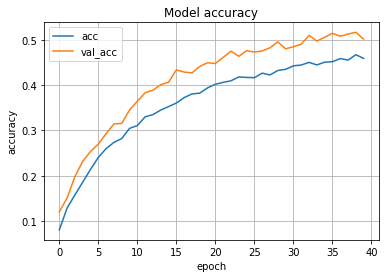

songs-1000-200-100-32-64


20new_songs-1000-200-100-32-128


KeyboardInterrupt: 

In [17]:
max_wordss = [1000, 5000, 10000, 20000]
pads = [200, 500, 1000, 2000]
dimensions = [100, 300]
conv_sizes = [32, 64, 128, 256, 512]
batch_sizes = [64, 128, 256]
datas = ['20new_songs', '20new', 'songs']

for max_words in max_wordss:
    tokenizer = load_tokenizer('model/tokenizer_' + str(max_words))
    for pad in pads:
        for dimension in dimensions:
            for conv_size in conv_sizes:
                for batch_size in batch_sizes:
                    for data in datas:
                        main(max_words, pad, dimension, conv_size, batch_size, data, tokenizer)
#max_words = max_wordss[0]
#pad = pads[0]
#dimension = dimensions[0]
#conv_size = conv_sizes[0]
#batch_size = batch_sizes[0]
#data = datas[0]